In [4]:
import numpy as np
from math import exp, sqrt, log
import pandas as pd
from copy import copy
import os
from scipy.stats import norm

In [5]:
os.chdir("/Users/Markus/Documents/Ex 5")
%matplotlib inline

#import implied vol and option premia data
implied_vols = pd.read_excel("Data.xlsx", sheet_name = "Implied vols", index_col = 0)
option_premia = pd.read_excel("Data.xlsx", sheet_name = "Call premia", index_col = 0)

implied_vols

,Implied vol
Strike,
50,30.000000
60,28.000000
70,27.334315
80,23.955320
90,20.617317
100,17.145899
110,13.725463
120,11.777155
130,11.346723


In [6]:
#set simulation parameters
s_0 = 100.
timesteps = 100
paths = 1000

r = 0.05
expiry = 2.

dtime = expiry/timesteps

In [7]:
#get random normal matrix
#np.random.seed(2)
random_normals = np.random.normal(size=[paths, timesteps])
print(random_normals[:5,:5])

[[ 0.76735732 -0.16284959 -1.19847317  1.77868548 -0.51001615]
 [ 1.50539658  0.1185895   0.29241905  0.21272996 -0.60600797]
 [ 0.50033811  0.91977602 -0.97192107 -1.03903788  0.09167847]
 [-0.4323842  -0.71944209  1.17728319  1.09667025 -0.59724368]
 [-0.79299049  2.03855471  2.27082902  0.71077664 -0.41682697]]


In [26]:
#1 path simulation
strike = 100
vol = implied_vols.loc[strike, "Implied vol"]/100.

S_values = []
S = s_0

for k in range(timesteps):
    random_normal = random_normals[4,k]
    S = S * exp((r-0.5*(vol**2))*dtime + vol*sqrt(dtime)*random_normal)
    S_values.append(S)
    
#MC BSM Call option value  
strike = 120
vol = implied_vols.loc[strike, "Implied vol"]/100.

payoff_sum = 0

for i in range(paths):
    
    S = s_0
    
    for k in range(timesteps):
        random_normal = random_normals[i,k]
        S = S * exp((r-0.5*(vol**2))*dtime + vol*sqrt(dtime)*random_normal)
    
    payoff = max(S-strike, 0) 
    payoff_sum = payoff_sum + payoff

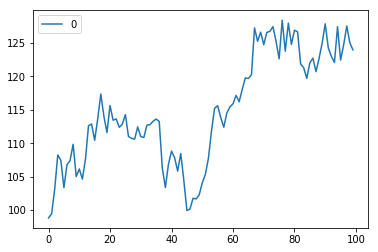

In [17]:
(pd.DataFrame(S_values)).plot()

In [27]:
Call_price = exp(-r*expiry)*payoff_sum/paths

print(Call_price)

option_premia.loc[strike, "MC BSM"] = copy(Call_price)

3.1764153243614697


In [28]:
option_premia.dropna()

,Premium,MC BSM
Strike,,
80,30.209683,28.730600
90,22.274272,21.121275
100,14.714982,13.890068
110,7.949722,7.423519
120,3.457534,3.176415


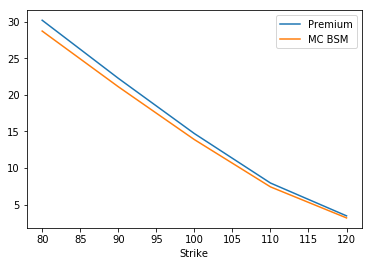

In [29]:
option_premia.dropna().plot()

In [8]:
local_vols = pd.DataFrame(columns = ["local_vol"])

d_impliedvol_d_strike = (implied_vols/100.).diff()/10.

d_impliedvol_d_strike

,Implied vol
Strike,
50,NaN
60,-0.002000
70,-0.000666
80,-0.003379
90,-0.003338
100,-0.003471
110,-0.003420
120,-0.001948
130,-0.000430


In [9]:
for strike in range(60,160,10):
    implied_vol = implied_vols.loc[strike, "Implied vol"]/100.
    d_1 = (log(s_0/strike) + (r + 0.5*implied_vol**2)*expiry)/(implied_vol*sqrt(expiry))
    local_vols.loc[strike, "local_vol"] =   (implied_vol/
                                            (1 + d_1 * strike * sqrt(expiry) * d_impliedvol_d_strike.loc[strike][0]))
local_vols = local_vols.applymap(float)

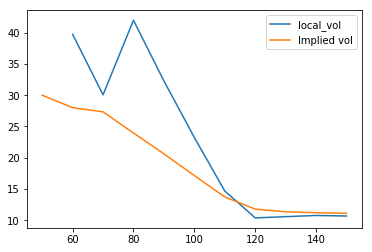

In [10]:
pd.concat([local_vols*100, implied_vols], axis = 1).plot()

In [11]:
local_vols

,local_vol
60,0.397379
70,0.300571
80,0.419828
90,0.322738
100,0.232324
110,0.146718
120,0.103682
130,0.105677
140,0.107582
150,0.106770


In [35]:
local_vol_interp(102)

0.2152029079813044

In [34]:
def local_vol_interp(S):
    if S<60:
        return local_vols.loc[60, "local_vol"]
    elif S>150:
        return local_vols.loc[150, "local_vol"]
    elif S in local_vols.index.values:
            return local_vols.loc[S, "local_vol"]
    else:
        interp = np.interp(S, local_vols.index, local_vols.iloc[:,0].values)
        return interp

In [40]:
#Local vol simulation
strike = 100

payoff_sum = 0

for i in range(paths):
    
    S = s_0
    
    for k in range(timesteps):
        random_normal = random_normals[i,k]
        S = S * exp((r-0.5*(local_vol_interp(S)**2))*dtime + local_vol_interp(S)*sqrt(dtime)*random_normal)
    
    payoff = max(S-strike, 0) 
    payoff_sum = payoff_sum + payoff

In [41]:
Call_price = exp(-r*expiry)*payoff_sum/paths

print(Call_price)

option_premia.loc[strike, "MC Local vol"] = copy(Call_price)

16.32707704667012


In [42]:
option_premia.dropna()

,Premium,MC BSM,MC Local vol
Strike,,,
80,30.209683,28.730600,29.951449
90,22.274272,21.121275,22.937582
100,14.714982,13.890068,16.327077


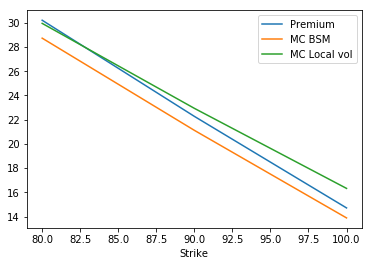

In [43]:
option_premia.dropna().plot()

In [47]:
#MC BSM Delta
strike = 100

vol = implied_vols.loc[strike, "Implied vol"]/100.

payoff_sum = 0

for i in range(paths):
    
    S = s_0 - 1 
    
    for k in range(timesteps):
        random_normal = random_normals[i,k]
        S = S * exp((r-0.5*(vol**2))*dtime + vol*sqrt(dtime)*random_normal)
    
    payoff = max(S-strike, 0) 
    payoff_sum = payoff_sum + payoff

In [48]:
Call_price = exp(-r*expiry)*payoff_sum/paths
S_99 = copy(Call_price)
print(S_99)


13.218904107631086


In [49]:
Delta = (S_101 - S_99) / 2.
print(Delta)

0.6773699911219451


In [12]:
#Analytical BSM delta
implied_vol_100 = implied_vols.loc[100, "Implied vol"]/100.
d_1 = (log(s_0/100) + (r + 0.5*implied_vol_100**2)*expiry)/(implied_vol_100*sqrt(expiry))
BSM_delta = norm.cdf(d_1)
print(BSM_delta)

0.7032066202812703


In [17]:
BSM_vega = s_0 * norm.pdf(d_1) * sqrt(expiry)
print(BSM_vega)
beta = (local_vols.diff()/10).loc[100, "local_vol"]/2

48.93125896136969


In [18]:
beta

-0.004520686424234031

In [19]:
#Approximated LV Delta
Local_vol_delta = BSM_delta + BSM_vega * beta
print(Local_vol_delta)

0.4820037421739266


In [57]:
#MS LV delta 
strike = 100

payoff_sum = 0

for i in range(paths):
    
    S = s_0 - 1
    
    for k in range(timesteps):
        random_normal = random_normals[i,k]
        S = S * exp((r-0.5*(local_vol_interp(S)**2))*dtime + local_vol_interp(S)*sqrt(dtime)*random_normal)
    
    payoff = max(S-strike, 0) 
    payoff_sum = payoff_sum + payoff

In [58]:
Call_price = exp(-r*expiry)*payoff_sum/paths
S_99 = copy(Call_price)
print(S_99)

15.825674349028548


In [59]:
Local_vol_delta = (S_101 - S_99) / 2.
print(Local_vol_delta)

0.5030546667829325


In [67]:
#FD BSM
S_max          = 200.
asset_step     = 1
t_step         = 0.00025

no_asset_steps = int(S_max/asset_step)

no_time_steps = int(expiry/t_step)

S = np.zeros(no_asset_steps+1)
V = np.zeros((no_asset_steps+1, no_time_steps+1))

strike = 100.
vol = implied_vols.loc[strike, "Implied vol"]/100.

for i in range(no_asset_steps+1):
    S[i] = i*asset_step
    V[i, no_time_steps] = max(S[i] - strike, 0)

for k in range(no_time_steps, 0, -1):
    for i in range(1,no_asset_steps):
        
        delta_term = r * S[i] * (V[i+1,k] - V[i-1,k]) / 2*asset_step
        gamma_term = 0.5*(vol**2)*(S[i]**2)*(V[i+1,k] + V[i-1,k] - 2*V[i,k])/(asset_step**2)
        
        theta_term = r*V[i,k] - gamma_term - delta_term
        V[i, k-1] = V[i,k] - theta_term * t_step
        
    V[0, k-1] = 0
    V[no_asset_steps, k-1] = 2*V[no_asset_steps-1, k-1] - V[no_asset_steps-2, k-1]

option_premia.loc[strike, "FDM BSM"] = V[100,0]

In [61]:
V

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.69280982e-33, 2.67736398e-33, 2.66200403e-33, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.57037772e-30, 1.56164631e-30, 1.55296191e-30, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.07514322e+02, 1.07513193e+02, 1.07512064e+02, ...,
        9.80025000e+01, 9.80012500e+01, 9.80000000e+01],
       [1.08513435e+02, 1.08512307e+02, 1.08511178e+02, ...,
        9.90025000e+01, 9.90012500e+01, 9.90000000e+01],
       [1.09512548e+02, 1.09511420e+02, 1.09510292e+02, ...,
        1.00002500e+02, 1.00001250e+02, 1.00000000e+02]])

In [65]:
option_premia.dropna()

,Premium,MC BSM,MC Local vol,FDM BSM
Strike,,,,
90,22.274272,21.121275,22.937582,22.272947
100,14.714982,13.890068,16.327077,14.713087


In [68]:
#FDM BSM delta
FDM_BSM_Delta = (V[101,0] - V[99,0]) / 2.
print(FDM_BSM_Delta)

0.7031594188945371


In [69]:
#FDM local vol
strike = 100.
vol = implied_vols.loc[strike, "Implied vol"]/100.

for i in range(no_asset_steps+1):
    S[i] = i*asset_step
    V[i, no_time_steps] = max(S[i] - strike, 0)

for k in range(no_time_steps, 0, -1):
    for i in range(1,no_asset_steps):
        
        vol = local_vol_interp(S[i])
        
        delta_term = r * S[i] * (V[i+1,k] - V[i-1,k]) / 2*asset_step
        gamma_term = 0.5*(vol**2)*(S[i]**2)*(V[i+1,k] + V[i-1,k] - 2*V[i,k])/(asset_step**2)
        
        theta_term = r*V[i,k] - gamma_term - delta_term
        V[i, k-1] = V[i,k] - theta_term * t_step
        
    V[0, k-1] = 0
    V[no_asset_steps, k-1] = 2*V[no_asset_steps-1, k-1] - V[no_asset_steps-2, k-1]

option_premia.loc[strike, "FDM Local vol"] = V[100,0]

In [70]:
option_premia.dropna()

,Premium,MC BSM,MC Local vol,FDM BSM,FDM Local vol
Strike,,,,,
100,14.714982,13.890068,16.327077,14.713087,16.974293


In [71]:
V[100,0]

16.97429265969222

In [72]:
#FDM LV delta
FDM_LV_Delta = (V[101,0] - V[99,0]) / 2.
print(FDM_LV_Delta)

0.5163176492855843
